In [13]:
import os
import glob
import pandas as pd
import numpy as np
import pandas as pd
from IPython.display import display 
import nltk
from nltk import sent_tokenize,word_tokenize
import itertools
from nltk.tokenize.treebank import TreebankWordDetokenizer
def func(i,j) :
    directory_path="C:/Users/rasyd/Documents/in5460/oblig1/RL-Microgrid-Coordination/data/residential/"
    entries = os.listdir(directory_path)[i:j]
    
    folders = [entry for entry in entries if os.path.join(directory_path, entry)]
    
    entries=[os.path.join(directory_path, folder) for folder in folders]
    
    
    
    
    
    # Generate the list using list comprehension
    
    
    
    # Initialize an empty DataFrame to store the combined data'C:/Users/rasyd/Documents/in5460/oblig1/USA_AK_Anchorage.Intl.AP.702730_TMY3'
    combined_data = pd.DataFrame()
    
    # Use glob to get a list of all files in the folder with a specific extension
    
    
    for file_path in entries:
        # Read the current file into a DataFrame
            current_data = pd.read_csv(file_path,encoding='utf-8')
            
            tokenize_col=current_data.columns
            
            
            
            tokenized_sentences_list = [sent_tokenize(text) for text in tokenize_col]
            tokenized_sentences_list = [word_tokenize(text) for text in tokenize_col]
            
            
            occurrences_electricity = np.array([(i, j) for i, sublist in enumerate(tokenized_sentences_list) for j, word in enumerate(sublist) if word == 'Electricity'])[:,0]
            
            
            Electricity_consumption_wind_solar=current_data[tokenize_col[occurrences_electricity]].sum(axis=1)
            
            current_data=Electricity_consumption_wind_solar
            
            
            # Add the columns of the current file to the combined_data DataFrame
            combined_data = pd.concat([combined_data, current_data], axis=1)
            
            # Now, combined_data contains the columns from all the imported files
            #print(combined_data.sum(axis=1))
    Series_type=combined_data.sum(axis=1)
    house_hold_data=Series_type.to_frame("Household_load")
        
    total_energy=Series_type.to_frame("Household_load")
    total_energy=np.array(total_energy).ravel()
    total_energy

    return total_energy
total_energy=func(0,100)



In [14]:
import numpy as np
import gym
from gym import spaces
from gym.spaces import Box, Dict, Discrete, MultiBinary, MultiDiscrete
import numpy as np
from stable_baselines3 import PPO,A2C
import numpy as np
import pandas as pd
from IPython.display import display 
import nltk
from nltk import sent_tokenize,word_tokenize
import itertools
from nltk.tokenize.treebank import TreebankWordDetokenizer

import numpy as np

# the cut -in windspeed (km/h =1/3.6 m/s), v^ci#
cutin_windspeed = 3
# the cut -off windspeed (km/h =1/3.6 m/s), v^co#
cutoff_windspeed = 11
# the rated windspeed (km/h =1/3.6 m/s), v^r#
rated_windspeed = 7
# the charging - discharging efficiency , eta#
charging_discharging_efficiency = 0.95
# the rate for discharging the battery ( MegaWatt ), b#
rate_battery_discharge = 2.5
# the unit operational and maintanance cost for generating power
# from solar PV (10^4 $/ MegaWattHour =10 $/ kWHour ), r_omc ^s#
unit_operational_cost_solar = 0.15
# the unit operational and maintanance cost for generating power
# from wind turbine (10^4 $/ MegaWattHour =10 $/ kWHour ), r_omc ^w#
unit_operational_cost_wind = 0.085
# the unit opeartional and maintanance cost for generating power
# from generator (10^4 $/ MegaWattHour =10 $/ kWHour ), r_omc ^g#
unit_operational_cost_generator = 0.55
# the unit operational and maintanance cost for battery storage system
# per unit charging / discharging cycle (10^4 $/ MegaWattHour =10 $/ kWHour ),
# r_omc ^b#
unit_operational_cost_battery = 0.95
# the capacity of battery storage system ( MegaWatt Hour =1000 kWHour ), e#
capacity_battery_storage = 300
# the maximum state of charge of battery system #
SOC_max = 0.95* capacity_battery_storage
# the minimum state of charge of battery system #
SOC_min = 0.05* capacity_battery_storage
# the area of the solar PV system (km ^2=1000*1000 m^2) , a#
area_solarPV = 14000
# the efficiency of the solar PV system , delta #
efficiency_solarPV = 0.2
# calculate the rated power of the wind turbine ,
# density of air (10^6 kg/km ^3=1 kg/m^3) , rho#
density_of_air = 1.225
# calculate the rated power of the wind turbine ,
# radius of the wind turbine blade (km =1000 m), r#
radius_wind_turbine_blade = 25
# calculate the rated power of the wind turbine ,
# average wind speed (km/h =1/3.6 m/s), v_avg ( from the windspeed table )#
average_wind_speed = 3.952
# calculate the rated power of the wind turbine , power coefficient , theta #
power_coefficient = 0.593
# calculate the rated power of the wind turbine ,
# gearbox transmission efficiency , eta_t #
gearbox_transmission_efficiency = 0.95
# calculate the rated power of the wind turbine ,
# electrical generator efficiency , eta_g #
electrical_generator_efficiency = 0.95
# the rated power of the wind turbine , RP_w ( MegaWatt =10^6 W),
# with the radius_wind_turbine_blade measured in km =10^3m,
# average wind speed measured in km/ hour =3.6 m/s,
# RP_w will be calculated as RP_w_numerical
# then RP_w in MegaWatt =(1 kg/m^3) *(10^3 m) *(10^3 m)
# *(3.6 m/s) *(3.6 m/s) *(3.6 m/s)* RP_w_numerical
# =3.6^3*10^6 RP_w_numerical W =3.6^3 RP_w_numerical MegaWatt #
rated_power_wind_turbine_original =\
    (0.5 * density_of_air * np.pi
     * radius_wind_turbine_blade
     * radius_wind_turbine_blade
     * average_wind_speed
     * average_wind_speed
     * average_wind_speed
     * power_coefficient
     * gearbox_transmission_efficiency
     * electrical_generator_efficiency)
rated_power_wind_turbine = rated_power_wind_turbine_original /1000
# the number of wind turbine in the onsite generation system , N_w#
number_windturbine = 1
# the number of generators , n_g#
number_generators = 1

# the rated output power of the generator ( MegaWatt =1000 kW), G_p#
rated_output_power_generator = 600

unit_reward_soldbackenergy=0.2





# read the solar irradiance and wind speed data from file #
# read the rate of consumption charge date from file #
file_SolarIrradiance = "SolarIrradiance.csv"
file_WindSpeed = "WindSpeed.csv"
file_rateConsumptionCharge = "rate_consumption_charge.csv"
# read the solar irradiace
data_solar = pd.read_csv(file_SolarIrradiance)

# solar irradiance measured by MegaWatt /km ^2
solarirradiance = np.array( data_solar.iloc[: ,3].dropna())
# read the windspeed
data_wind = pd.read_csv( file_WindSpeed )
windspeed =  np.array( data_wind.iloc[: ,3].dropna())# windspeed measured by km/h =1/3.6 m/s

# read the rate of consumption charge
data_rate_consumption_charge =pd.read_csv( file_rateConsumptionCharge ).dropna()
#rate_consumption_charge = np.array( data_rate_consumption_charge.iloc[: ,4])/10
# rate of consumption charge measured by 10^4 $/ MegaWatt =10 $/kWh





P_g_t=np.array( data_rate_consumption_charge.iloc[: ,4])/10 #cost of using windmills,and PV and genrerator for microgrid





def generate_binary_combinations(num_vars):
    # Generate all binary combinations for num_vars as a list of lists
    binary_combinations = np.unpackbits(np.arange(2**num_vars, dtype=np.uint8)[:, np.newaxis], axis=1)
    binary_combinations = binary_combinations[:, -num_vars:]
    binary_combinations_list = binary_combinations.tolist()
    return binary_combinations_list




class Microgrid:
    def __init__(self,
                 workingstatus=np.array([0, 0, 0]),
                 SOC=0,
                 actions_adjustingstatus=np.array([0, 0, 0]),
                 actions_solar=np.array([0, 0, 0]),
                 actions_wind=np.array([0, 0, 0]),
                 actions_generator=np.array([0, 0, 0]),
                 actions_purchased=np.array([0, 0]),
                 actions_discharged=0,
                 solarirradiance=solarirradiance,
                 windspeed=windspeed):
        self.workingstatus = workingstatus
        self.SOC = SOC
        self.actions_adjustingstatus = actions_adjustingstatus
        self.actions_solar = actions_solar
        self.actions_wind = actions_wind
        self.actions_generator = actions_generator
        self.actions_purchased = actions_purchased
        self.actions_discharged = actions_discharged
        self.solarirradiance = solarirradiance
        self.windspeed = windspeed
        self.count=0
        
    def transition(self):
       
        workingstatus = self.workingstatus
        SOC = self.SOC
        if self.actions_adjustingstatus[0] == 1:
            workingstatus[0] = 1
        else:
            workingstatus[0] = 0
        
        if self.actions_adjustingstatus[1] == 1 and cutoff_windspeed >= self.windspeed[self.count] >= cutin_windspeed:
            workingstatus[1] = 1
        
        if self.actions_adjustingstatus[2] == 1:
            workingstatus[2] = 1
        else:
            workingstatus[2] = 0
        
        SOC = (self.SOC + (self.actions_solar[1] + self.actions_wind[1] + self.actions_generator[1]
                           + self.actions_purchased[1]) * charging_discharging_efficiency
               - self.actions_discharged / charging_discharging_efficiency)
        #print(SOC)
        SOC = max(min(SOC, SOC_max), SOC_min)
        
        return workingstatus, SOC

    def EnergyConsumption(self):

     
        return -(self.actions_solar[0] + self.actions_wind[0] + self.actions_generator[0] + self.actions_discharged)

    def energy_generated_solar(self):
        #print(self.solarirradiance[self.count])
        if self.workingstatus[0] == 1:
            energy_generated_solar = self.solarirradiance[self.count] * area_solarPV * efficiency_solarPV/1000 
        else:
            energy_generated_solar = 0
        return energy_generated_solar

    def energy_generated_wind(self):
        Delta_t=1
        if self.workingstatus[1] == 1 and rated_windspeed > self.windspeed[self.count] >= cutin_windspeed:
            energy_generated_wind = (number_windturbine
                                     * rated_power_wind_turbine
                                     * (self.windspeed[self.count] - cutin_windspeed) / (rated_windspeed - cutin_windspeed))
            energy_generated_wind = 0
        else:
            #if self.workingstatus[1] == 1 and cutoff_windspeed > self.windspeed[self.count] >= rated_windspeed:
                #energy_generated_wind = number_windturbine * rated_power_wind_turbine * Delta_t
            #else:
            energy_generated_wind = 0
        return energy_generated_wind

    def energy_generated_generator(self):
        Delta_t=1
        if self.workingstatus[2] == 1:
            energy_generated_generator = number_generators * rated_output_power_generator * Delta_t
            energy_generated_generator = 0
        else:
            energy_generated_generator = 0
        return energy_generated_generator

    def OperationalCost(self):
        Delta_t=1
        energy_generated_solar = self.energy_generated_solar()
        energy_generated_wind = self.energy_generated_wind()
        energy_generated_generator = self.energy_generated_generator()
        
        operational_cost = (energy_generated_solar * unit_operational_cost_solar
                            + energy_generated_wind * unit_operational_cost_wind
                            + energy_generated_generator * unit_operational_cost_generator)
        
        operational_cost += ((self.actions_discharged + self.actions_solar[1] + self.actions_wind[1] +
                              self.actions_generator[1]) * Delta_t * unit_operational_cost_battery /
                             (2 * capacity_battery_storage * (SOC_max - SOC_min)))
        
        return operational_cost

    def SoldBackReward(self):
      
        return ((self.actions_solar[2] + self.actions_wind[2] + self.actions_generator[2]) 
                )

    
        
        




class CustomEnv(gym.Env):
    def __init__(self, binary_combinations_1, binary_combinations_2, binary_combinations_3,P_g_t,windspeed,solarirradiance,total_energy,number_generators):
        super(CustomEnv, self).__init__()
       
        #self.binary_combinations_1 = binary_combinations_1
        #self.binary_combinations_2 = binary_combinations_2
        #self.binary_combinations_3 = binary_combinations_3
        self.microgrid_instance = Microgrid()
        self.count=0
        self.mutiply=0
        self.observation_space = spaces.Box(low=np.array([0, 0, 0, 0,0,0,0]), high=np.array([1, 1, 1, 1000,1000,1000,1000]), dtype=np.float32)
        self.action_space = MultiDiscrete([8, 8, 8, 8, 4, 2])
        
    def step(self, action):
      
       #if you want another episode lenght smaller then data size activate multiply in if done condition further down
        self.microgrid_instance.count=self.microgrid_instance.count+self.mutiply*(self.count-1)+1
        
        #print(self.microgrid_instance.count)
        adjusting_status = binary_combinations_3[action[0]]
        solar_actions = binary_combinations_3[action[1]]
        #print(solar_actions)
        wind_actions = binary_combinations_3[action[2]]
        generator_actions = binary_combinations_3[action[3]]
        purchased_actions = binary_combinations_2[action[4]]
        purchased_discharged = binary_combinations_1[action[5]]

        """
        adjusting_status = action[0:3]
        solar_actions = action[3:6]
        wind_actions = action[6:9]
        generator_actions = action[9:12]
        purchased_actions = action[12:14]
        purchased_discharged = action[14]
        """
        self.microgrid_instance.actions_adjustingstatus = np.array(adjusting_status)
        self.microgrid_instance.actions_solar = np.array(solar_actions)
        self.microgrid_instance.actions_wind = np.array(wind_actions)
        self.microgrid_instance.actions_generator = np.array(generator_actions)
        #print(self.microgrid_instance.actions_generator)
        self.microgrid_instance.actions_purchased = np.array(purchased_actions)
        self.microgrid_instance.actions_discharged = purchased_discharged[0]  
     
        
        """
        print("Actions Solar Shape:", self.microgrid_instance.actions_solar.shape)
        print("Actions Wind Shape:", self.microgrid_instance.actions_wind.shape)
        print("Actions Generator Shape:", self.microgrid_instance.actions_generator.shape)
        print("Actions Purchased Shape:", self.microgrid_instance.actions_purchased.shape)
        """
        #print(self.microgrid_instance.transition())
        state_working_space,state_Soc = self.microgrid_instance.transition()
        state=np.concatenate((state_working_space, [state_Soc,total_energy[self.microgrid_instance.count],
                                  windspeed[self.microgrid_instance.count],solarirradiance[self.microgrid_instance.count]])).astype(int)
        #self.microgrid_instance.SoldBackReward()=microgrid_instance.SoldBackReward()
      
        
        

        S_t_indicator = self.microgrid_instance.SoldBackReward()
        #O_t = self.microgrid_instance.OperationalCost()
        Total_E_t_micro = (self.microgrid_instance.actions_discharged / charging_discharging_efficiency+self.microgrid_instance.energy_generated_solar()
                           +self.microgrid_instance.energy_generated_wind()+self.microgrid_instance.energy_generated_generator())
        #print(self.microgrid_instance.energy_generated_generator())
        #print(self.Total_E_t_micro)
        if np.floor(S_t_indicator)!=0 and sum(self.microgrid_instance.actions_adjustingstatus)!=0:
            S_t_energy = self.microgrid_instance.SoldBackReward()*Total_E_t_micro
        else:
           S_t_energy=0
            
        O_t = self.microgrid_instance.OperationalCost()
        Total_E_t_micro=Total_E_t_micro-S_t_energy
        S_t=S_t_energy*unit_reward_soldbackenergy
        #Calculate the energy needed for the load after generation and buy thhe rest, self.microgrid_instance.EnergyConsumption() is negative
        Rest_after_consumption_cost = (total_energy[self.microgrid_instance.count]+
                                       Total_E_t_micro*self.microgrid_instance.EnergyConsumption())
        #print(Total_E_t_micro)
        #print(self.microgrid_instance.EnergyConsumption())

        
        if Rest_after_consumption_cost>0: 
           self.microgrid_instance.actions_purchased[0]=1 
           #E_t=self.microgrid_instance.actions_purchased[0]*Rest_after_consumption_cost*(P_g_t[self.microgrid_instance.count])
           E_t=self.microgrid_instance.actions_purchased[0]*Rest_after_consumption_cost 
        else:
             
             E_t=0
        
        #*self.microgrid_instance.EnergyConsumption()
      
        #E_t.shape
        #reward =-(E_t+O_t - S_t)
        reward=-(0.25*E_t**2*P_g_t[self.microgrid_instance.count]+0.5*E_t*P_g_t[self.microgrid_instance.count])
        
        #print(P_g_t[self.microgrid_instance.count])
        
        done=False
        if self.microgrid_instance.count==8639:
           done = True
           #self.count+=163
           #self.mutiply+1
        #print( self.reward )

        
        info={"Solar_power_generation":self.microgrid_instance.energy_generated_solar(),
              "Wind_power_generation":self.microgrid_instance.energy_generated_wind(),
             "energy_generated_generator":self.microgrid_instance.energy_generated_generator(),
             "reward":reward,
              "S_t":S_t,
              "O_t":O_t,
              "E_t":E_t,
              "state_Soc":state_Soc
             }
        return state, reward, done,info 
        
    def reset(self):
        self.microgrid_instance = Microgrid()  # Create a new Microgrid instance for each episode
        state_working_space,state_Soc = self.microgrid_instance.transition()
        
        state=np.concatenate((state_working_space, [state_Soc,total_energy[self.microgrid_instance.count],
                                  windspeed[self.microgrid_instance.count],solarirradiance[self.microgrid_instance.count]])).astype(int)
        
        
        #self.microgrid_instance.count=self.microgrid_instance.count+10*self.count
        #self.microgrid_instance.count=self.count 
        #print(self.state)
        return state

    def render(self):
        pass



num_binary_vars = 3  # Change this to the number of binary variables you have
binary_combinations_3 = generate_binary_combinations(num_binary_vars)

num_binary_vars = 2  # Change this to the number of binary variables you have
binary_combinations_2 = generate_binary_combinations(num_binary_vars)

num_binary_vars = 1  # Change this to the number of binary variables you have
binary_combinations_1 = generate_binary_combinations(num_binary_vars)


env = CustomEnv( binary_combinations_1, binary_combinations_2, binary_combinations_3,np.array(P_g_t), np.array(windspeed),np.array(solarirradiance),np.array(total_energy),number_generators)


C:\Users\rasyd\anaconda3\envs\micro\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [15]:
model = PPO("MlpPolicy", env, verbose=1,ent_coef=0.01,policy_kwargs={"net_arch": [64, 64]},learning_rate=0.01)

model.learn(total_timesteps=int(1e5))

learned_policy = model.policy



Using cpu device


C:\Users\rasyd\anaconda3\envs\micro\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 557  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 459        |
|    iterations           | 2          |
|    time_elapsed         | 8          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00783401 |
|    clip_fraction        | 0.0408     |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.4      |
|    explained_variance   | -5.96e-07  |
|    learning_rate        | 0.01       |
|    loss                 | 2.97e+09   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 4.64e+09   |
----------------

In [16]:
#predicting on new 16*6 housholds not used for used to train plolicy
import numpy as np

total_energy=func(101,200)
env = CustomEnv( binary_combinations_1, binary_combinations_2, binary_combinations_3,np.array(P_g_t), np.array(windspeed),np.array(solarirradiance),np.array(total_energy),number_generators)

obs = env.reset()  # Reset the environment to get the initial observation/state
done = False 
#obs = env.reset()
count=0
#done=False
n=8760
Solar_power=np.zeros(n)
Wind_power=np.zeros(n)
generator_power=np.zeros(n)
Cost=np.zeros(n)
operational_cost=np.zeros(n)
Sell_back_to_grid=np.zeros(n)
E_t=np.zeros(n)
state_Soc=np.zeros(n)

while True:
    #print(count)
    # Take a random action
    action, _ = learned_policy.predict(obs, deterministic=False)  # Predict action based on the current observation
    obs, reward, done, info = env.step(action)
    info_to_list=list(info.values())
    
    Solar_power[count]=info_to_list[0]
    Wind_power[count]=info_to_list[1]
    generator_power[count]=info_to_list[2]
    Cost[count]=info_to_list[3]
    Sell_back_to_grid[count]=info_to_list[4]
    operational_cost[count]=info_to_list[5]
    E_t[count]=info_to_list[6]
    state_Soc[count]=info_to_list[7]
    count+=1
    #print(obs)
    
    if done == True:
        break

#env.close()



C:\Users\rasyd\anaconda3\envs\micro\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


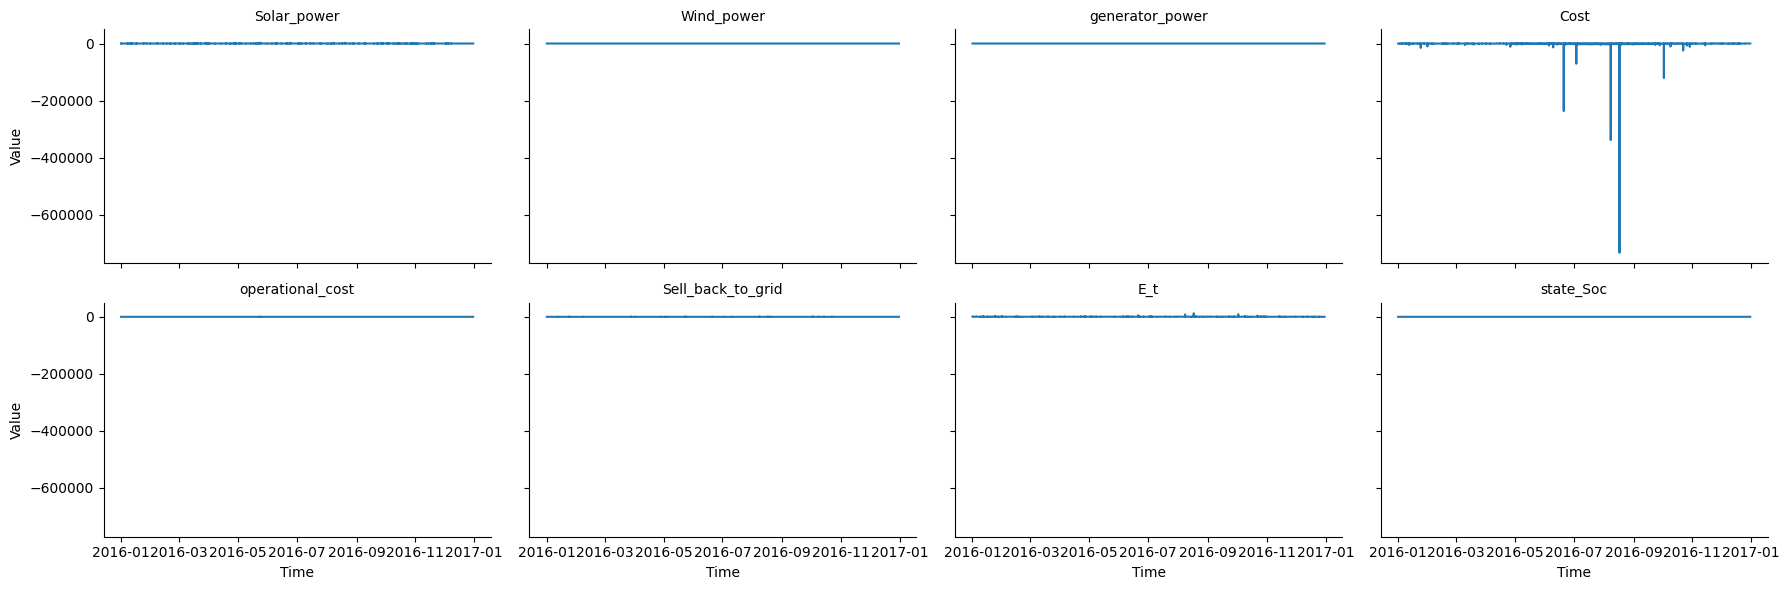

In [17]:
#plot of time evelution of what is generated and the cost components for every time-step
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


num_points = 8760
time_index = pd.date_range(start='2016-01-01', periods=num_points, freq='H')


data = {
    "Time": time_index,
    "Solar_power": Solar_power,
    "Wind_power": Wind_power,
    "generator_power": generator_power,
    "Cost": Cost,
    "operational_cost": operational_cost,
    "Sell_back_to_grid":Sell_back_to_grid,
    "E_t":E_t,
    "state_Soc":state_Soc
}
df=pd.DataFrame(data)
df_melted = df.melt(id_vars=["Time"], value_vars=["Solar_power", "Wind_power", "generator_power", "Cost", "operational_cost", "Sell_back_to_grid","E_t","state_Soc"])

# Create a facet grid
g = sns.FacetGrid(df_melted, col="variable", col_wrap=4, height=3, aspect=1.5)
g.map(sns.lineplot, "Time", "value")
g.set_axis_labels("Time", "Value")
g.set_titles(col_template="{col_name}")
plt.show()

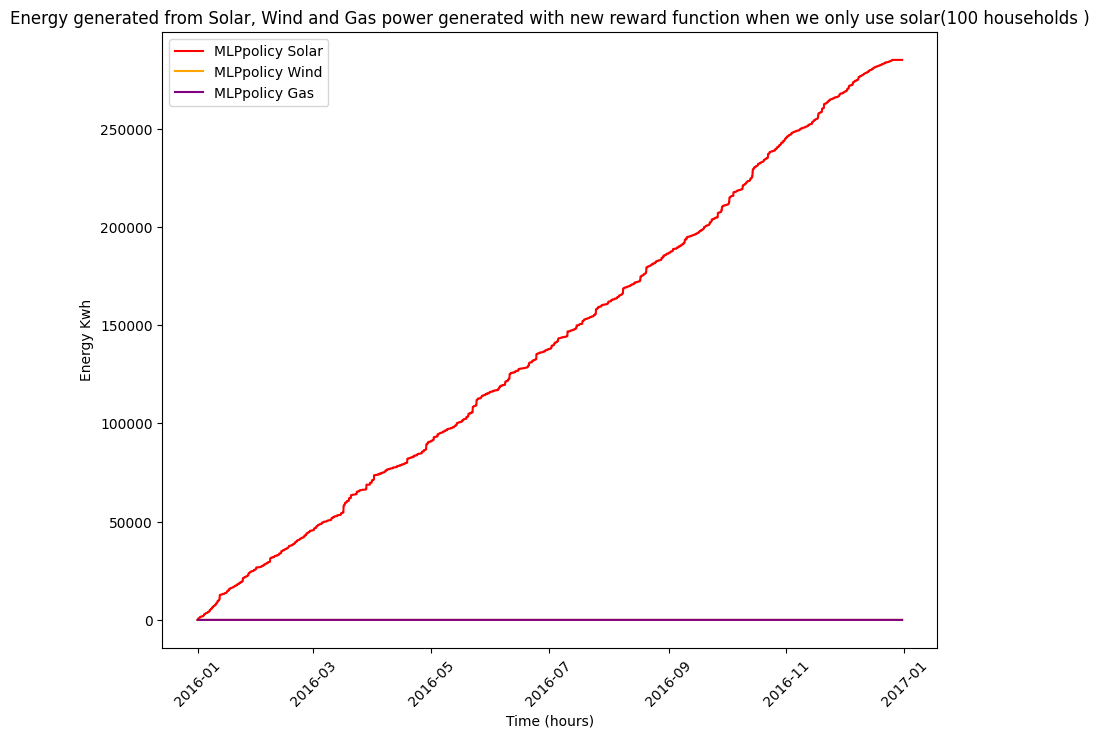

In [18]:

#For PPO algorithm accumulated wind an solar energy generation,We see that no penerator power is genetated
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import ticker


Solar_power_accumulated=np.cumsum(Solar_power)
Wind_power_accumulated=np.cumsum(Wind_power)
generator_power_acumulated=np.cumsum(generator_power)

data = {
    "Time": time_index,
    "Solar_power": Solar_power_accumulated,
    "Wind_power": Wind_power_accumulated,
    "generator_power": generator_power_acumulated,
    
}


df = pd.DataFrame(data)
    #df2 = pd.DataFrame(data2)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df["Time"], df["Solar_power"], color="red", label='MLPpolicy Solar')
ax.plot(df["Time"], df["Wind_power"], color="orange", label='MLPpolicy Wind')
ax.plot(df["Time"], df["generator_power"], color='purple', label='MLPpolicy Gas')



ax.set_xlabel("Time (hours)")
ax.set_ylabel("Energy Kwh")
plt.title("Energy generated from Solar, Wind and Gas power generated with new reward function when we only use solar(100 households )")
plt.xticks(rotation=45)
plt.legend()
plt.show()

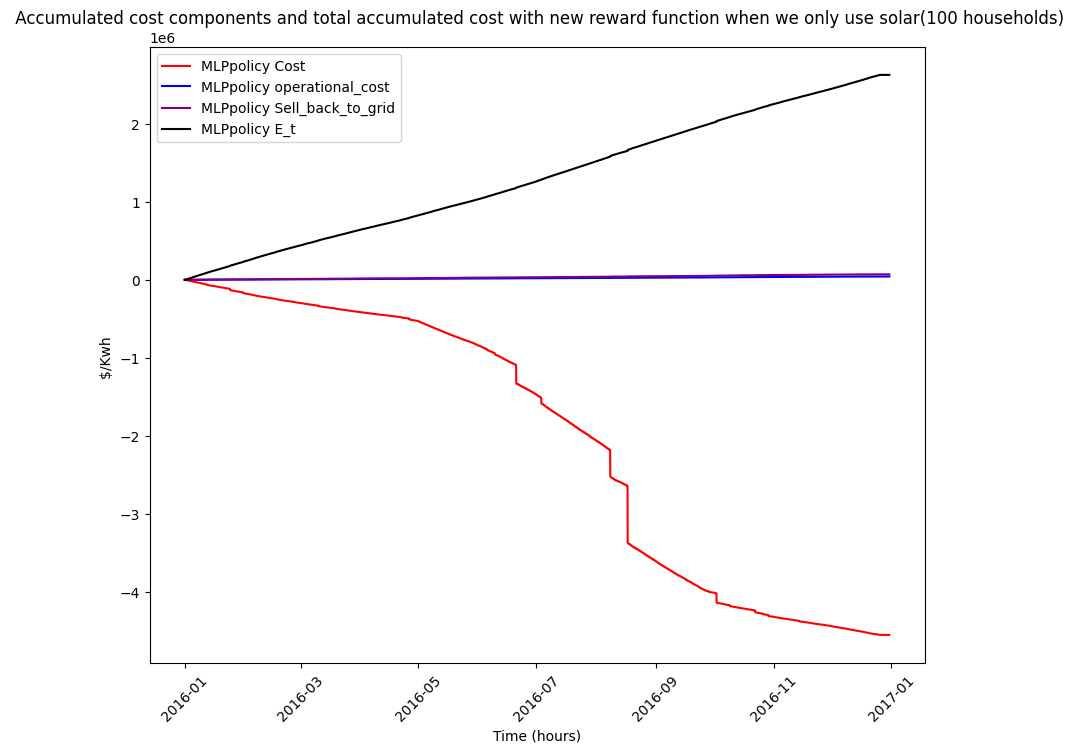

In [19]:
#Accumulated Cost,accumulated operational cost,accumulated sellback to grid,accumulated Energy bought from grid

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import ticker


Cost_accumulated=np.cumsum(np.array(Cost))
operational_cost_accumulated=np.cumsum(operational_cost)
Sell_back_to_grid_acumulated=np.cumsum(Sell_back_to_grid)
E_t_acumulated=np.cumsum(E_t)
time_index = pd.date_range(start='2016-01-01', periods=num_points, freq='H')
data = {
    "Time": time_index,
    "Cost": Cost_accumulated,
    "operational_cost": operational_cost_accumulated,
    "Sell_back_to_grid":Sell_back_to_grid_acumulated,
    "E_t":E_t_acumulated,
    "state_Soc":state_Soc
}


df = pd.DataFrame(data)
    #df2 = pd.DataFrame(data2)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df["Time"], df["Cost"], color="red", label='MLPpolicy Cost')
ax.plot(df["Time"], df["operational_cost"], color="blue", label='MLPpolicy operational_cost')
ax.plot(df["Time"], df["Sell_back_to_grid"], color='purple', label='MLPpolicy Sell_back_to_grid')
ax.plot(df["Time"], df["E_t"], color='black', label='MLPpolicy E_t')


ax.set_xlabel("Time (hours)")
ax.set_ylabel("$/Kwh ")
plt.title(" Accumulated cost components and total accumulated cost with new reward function when we only use solar(100 households)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [20]:
#Random policy tested on the same data

#random policy
env = CustomEnv( binary_combinations_1, binary_combinations_2, binary_combinations_3,np.array(P_g_t), np.array(windspeed),np.array(solarirradiance),np.array(total_energy),number_generators)

import numpy as np
obs = env.reset()  # Reset the environment to get the initial observation/state
done = False 
#obs = env.reset()
count=0
#done=False
n=8769
Solar_power=np.zeros(n)
Wind_power=np.zeros(n)
generator_power=np.zeros(n)
Cost=np.zeros(n)
operational_cost=np.zeros(n)
Sell_back_to_grid=np.zeros(n)
E_t=np.zeros(n)
state_Soc=np.zeros(n)
while True:
    # Take a random action
    action = env.action_space.sample()  # Predict action based on the current observation
    obs, reward, done, info = env.step(action)
    info_to_list=list(info.values())
    #print(info_to_list)                  
    Solar_power[count]=info_to_list[0]
    Wind_power[count]=info_to_list[1]
    generator_power[count]=info_to_list[2]
    Cost[count]=info_to_list[3]
    Sell_back_to_grid[count]=info_to_list[4]
    operational_cost[count]=info_to_list[5]
    E_t[count]=info_to_list[6]
    state_Soc[count]=info_to_list[7]
    count+=1
    
    
   
    
    if done == True:
        break

C:\Users\rasyd\anaconda3\envs\micro\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


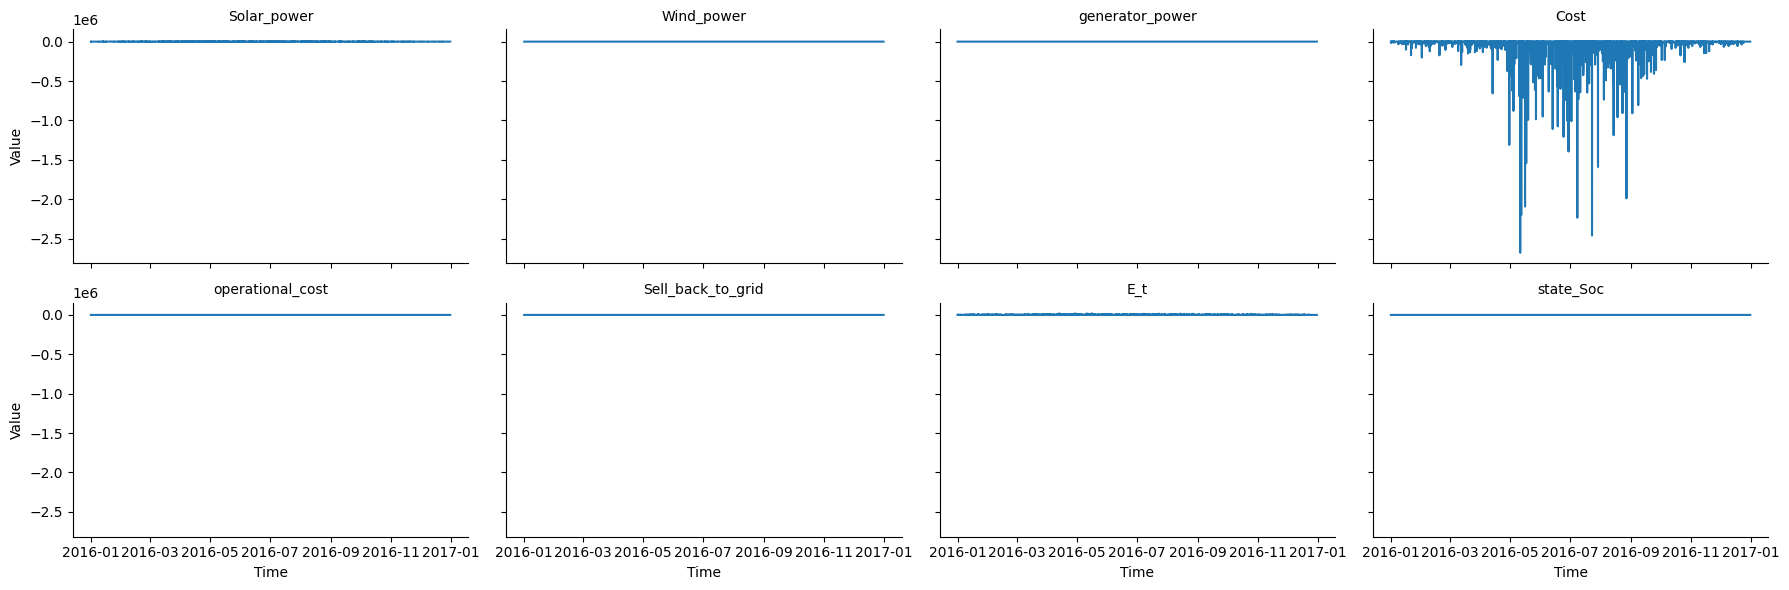

In [21]:
#plot results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a DataFrame with your time series data
# Replace these with your actual data
num_points = 8769
time_index = pd.date_range(start='2016-01-01', periods=num_points, freq='H')


data = {
    "Time": time_index,
    "Solar_power": Solar_power,
    "Wind_power": Wind_power,
    "generator_power": generator_power,
    "Cost": Cost,
    "operational_cost": operational_cost,
    "Sell_back_to_grid":Sell_back_to_grid,
    "E_t":E_t,
    "state_Soc":state_Soc
}
df=pd.DataFrame(data)
df_melted = df.melt(id_vars=["Time"], value_vars=["Solar_power", "Wind_power", "generator_power", "Cost", "operational_cost", "Sell_back_to_grid","E_t","state_Soc"])

# Create a facet grid
g = sns.FacetGrid(df_melted, col="variable", col_wrap=4, height=3, aspect=1.5)
g.map(sns.lineplot, "Time", "value")
g.set_axis_labels("Time", "Value")
g.set_titles(col_template="{col_name}")
plt.show()
env.close()

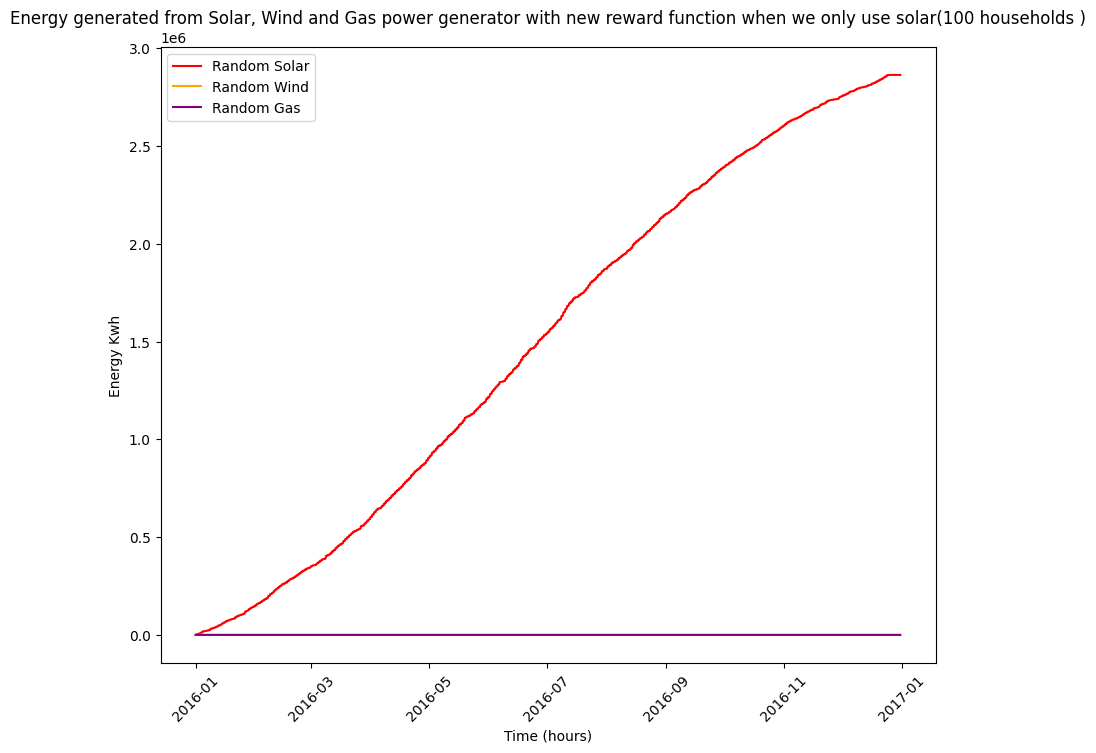

In [22]:
#We see that for the random policy it is actually using less solar because it starts using the generator as well which is not the case for PPO.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import ticker


Solar_power_accumulated=np.cumsum(Solar_power)
Wind_power_accumulated=np.cumsum(Wind_power)
generator_power_acumulated=np.cumsum(generator_power)
data = {
    "Time": time_index,
    "Solar_power": Solar_power_accumulated,
    "Wind_power": Wind_power_accumulated,
    "generator_power": generator_power_acumulated,
    
}


df = pd.DataFrame(data)
    #df2 = pd.DataFrame(data2)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df["Time"], df["Solar_power"], color="red", label='Random Solar')
ax.plot(df["Time"], df["Wind_power"], color="orange", label='Random Wind')
ax.plot(df["Time"], df["generator_power"], color='purple', label='Random Gas')

#ax.semilogy(df2["Time"], df2["Solar_power"], color='blue', label='PPO Solar')
#ax.semilogy(df2["Time"], df2["Wind_power"], color='green', label='PPO Wind')
#ax.semilogy(df2["Time"], df2["Gas_generator"], color='cyan', label='PPO Gas')

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Energy Kwh")
plt.title("Energy generated from Solar, Wind and Gas power generator with new reward function when we only use solar(100 households )")
plt.xticks(rotation=45)
plt.legend()
plt.show()

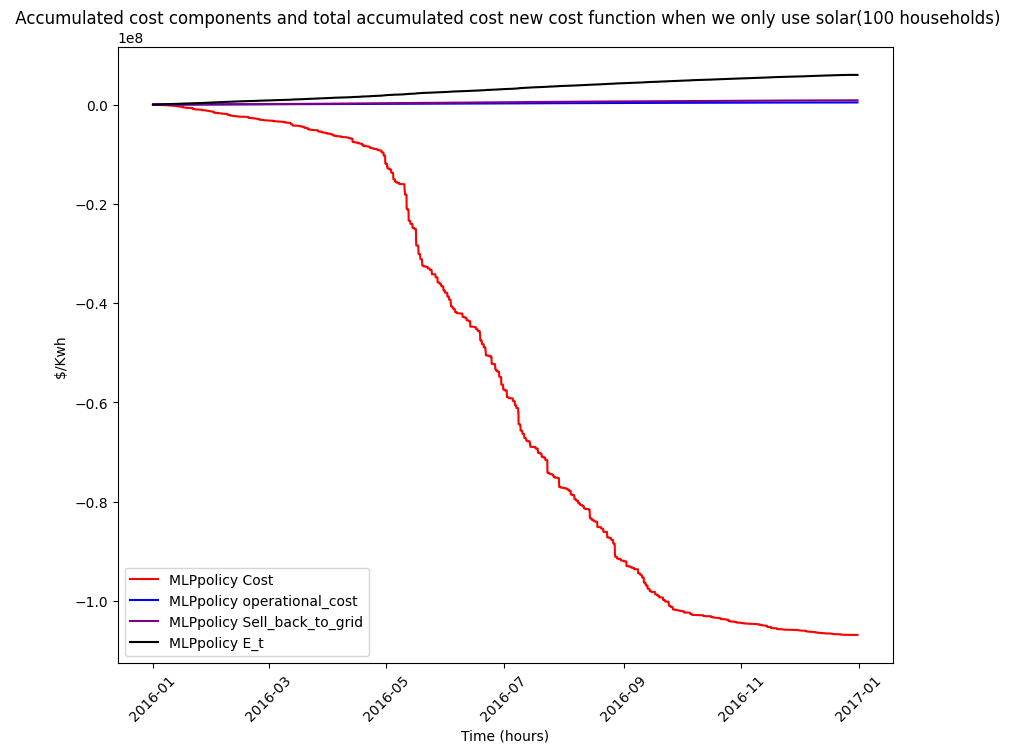

In [23]:

#We see that the sellback is lower for the Random policy, we aklso see that the cost is greater for the randompolicy in comparison with PPO.It buys almost
#the more from the grid the sellback is lower,in addtion of the use of the generator instead of solar,are some observation.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import ticker


Cost_accumulated=np.cumsum(np.array(Cost))
operational_cost_accumulated=np.cumsum(operational_cost)
Sell_back_to_grid_acumulated=np.cumsum(Sell_back_to_grid)
E_t_acumulated=np.cumsum(E_t)
time_index = pd.date_range(start='2016-01-01', periods=num_points, freq='H')
data = {
    "Time": time_index,
    "Cost": Cost_accumulated,
    "operational_cost": operational_cost_accumulated,
    "Sell_back_to_grid":Sell_back_to_grid_acumulated,
    "E_t":E_t_acumulated,
    "state_Soc":state_Soc
}


df = pd.DataFrame(data)
    #df2 = pd.DataFrame(data2)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df["Time"], df["Cost"], color="red", label='MLPpolicy Cost')
ax.plot(df["Time"], df["operational_cost"], color="blue", label='MLPpolicy operational_cost')
ax.plot(df["Time"], df["Sell_back_to_grid"], color='purple', label='MLPpolicy Sell_back_to_grid')
ax.plot(df["Time"], df["E_t"], color='black', label='MLPpolicy E_t')


ax.set_xlabel("Time (hours)")
ax.set_ylabel("$/Kwh ")
plt.title(" Accumulated cost components and total accumulated cost new cost function when we only use solar(100 households)")
plt.xticks(rotation=45)
plt.legend()
plt.show()